In [1]:
#https://www.tensorflow.org/hub/tutorials/tf2_image_retraining
import itertools
import os
import shutil

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import json
import kerastuner as kt
import PIL

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
GOOD = 0
BAD = 1

/home/jupyter/large-dataset/train-data-large/Good: 333
/home/jupyter/large-dataset/train-data-large/Bad: 455
/home/jupyter/large-dataset/train-augmented-data-large/Good: 788
/home/jupyter/large-dataset/train-augmented-data-large/Bad: 1034


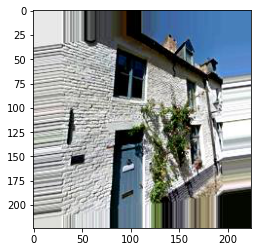

In [3]:
#reading training set of large dataset and augmented
train_data=[]
train_labels=[]
train_imagePaths = []
train_data_dir = "/home/jupyter/large-dataset/train-data-large"
train_aug_data_dir = "/home/jupyter/large-dataset/train-augmented-data-large"
for direct in [train_data_dir, train_aug_data_dir]:
    for label in os.listdir(direct):
        listdir = os.listdir(os.path.sep.join([direct,label]))
        if label == 'Good':
            bin_label = GOOD
        elif label == 'Bad':
            bin_label = BAD
        for filename in listdir:
            imagePath = os.path.sep.join([direct, label, filename])
            image = load_img(imagePath)
            plt.imshow(image)
            image = img_to_array(image) / 255.0
            train_data.append(image)
            train_labels.append(bin_label)
            train_imagePaths.append(imagePath)
        print(os.path.sep.join([direct,label]) + ": " + str(len(train_data)))
train_data = np.array(train_data)
train_labels = np.array(train_labels)
train_imagePaths = np.array(train_imagePaths)

/home/jupyter/large-dataset/validation-data-large/Good: 70
/home/jupyter/large-dataset/validation-data-large/Bad: 98


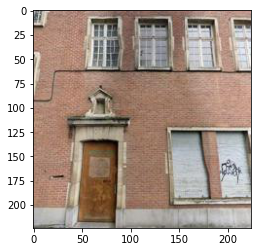

In [4]:
#reading validation set of large dataset and augmented
val_data=[]
val_labels=[]
val_imagePaths = []
val_data_dir = "/home/jupyter/large-dataset/validation-data-large"
for label in os.listdir(val_data_dir):
    listdir = os.listdir(os.path.sep.join([val_data_dir,label]))
    if label == 'Good':
        bin_label = GOOD
    elif label == 'Bad':
        bin_label = BAD
    for filename in listdir:
        imagePath = os.path.sep.join([val_data_dir, label, filename])
        image = load_img(imagePath)
        plt.imshow(image)
        image = img_to_array(image) / 255.0
        val_data.append(image)
        val_labels.append(bin_label)
        val_imagePaths.append(imagePath)
    print(os.path.sep.join([val_data_dir,label]) + ": " + str(len(val_data)))
val_data = np.array(val_data)
val_labels = np.array(val_labels)
val_imagePaths = np.array(val_imagePaths)

In [5]:
def model_builder(hp):
    dense = DenseNet201(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
    hp_dropout1 = hp.Choice('rate1', values=[0.2, 0.5, 0.7])
    head = tf.keras.layers.Dropout(rate=hp_dropout1)(dense.output)
    x = GlobalAveragePooling2D()(head)
    x = BatchNormalization()(x)
    hp_dropout2 = hp.Choice('rate2', values=[0.0, 0.2, 0.5])
    x = Dropout(hp_dropout2)(x)
    x = Dense(1024,activation='relu')(x) 
    x = Dense(512,activation='relu')(x) 
    x = BatchNormalization()(x)
    hp_dropout3 = hp.Choice('rate3', values=[0.0, 0.2, 0.5])
    x = Dropout(hp_dropout3)(x)
    head = tf.keras.layers.Dense(1, activation='sigmoid',
                              kernel_regularizer=tf.keras.regularizers.l2(0.0001), name="class_label")(x)
    model = Model(
        inputs=dense.input,
        outputs=(head))
    hp_frozen_layers = hp.Choice('num_frozen_layers', values = [-9, -11, -18, -25, -32])
    for layer in model.layers[:hp_frozen_layers]:
        layer.trainable = False
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
      optimizer=tf.keras.optimizers.SGD(lr=hp_learning_rate), 
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
      metrics=['accuracy'])
    return model

In [6]:
#tf.debugging.set_log_device_placement(True)
#with tf.device('/CPU:0'):
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='/home/jupyter/Cropping-tuner/',
                     project_name='DenseNetLargeTuner')
tuner.search_space_summary()

Search space summary
Default search space size: 5
rate1 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.5, 0.7], 'ordered': True}
rate2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.5], 'ordered': True}
rate3 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.5], 'ordered': True}
num_frozen_layers (Choice)
{'default': -9, 'conditions': [], 'values': [-9, -11, -18, -25, -32], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [7]:
#tuning
steps_per_epoch = len(train_data) // BATCH_SIZE
validation_steps = len(val_data) // BATCH_SIZE
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)
#tf.debugging.set_log_device_placement(True)
#with tf.device('/CPU:0'):
tuner.search(train_data, train_labels, epochs=50, steps_per_epoch=steps_per_epoch, 
         validation_data=(val_data, val_labels), validation_steps=validation_steps, callbacks=[callback])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 04m 08s]
val_accuracy: 0.8979591727256775

Best val_accuracy So Far: 0.9387755393981934
Total elapsed time: 01h 08m 42s
INFO:tensorflow:Oracle triggered exit


In [8]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('lr: '+str(best_hps['learning_rate']))
print('layers: '+str(best_hps['num_frozen_layers']))
print('rate1: '+str(best_hps['rate1']))
print('rate2: '+str(best_hps['rate2']))
print('rate3: '+str(best_hps['rate3']))

lr: 0.01
layers: -25
rate1: 0.7
rate2: 0.0
rate3: 0.5


In [9]:
#training
model = tuner.hypermodel.build(best_hps)
model.summary()
hist = model.fit(
    train_data, train_labels,
    epochs=50, steps_per_epoch=steps_per_epoch,
    validation_data=(val_data, val_labels),
    validation_steps=validation_steps, callbacks=[callback]).history

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

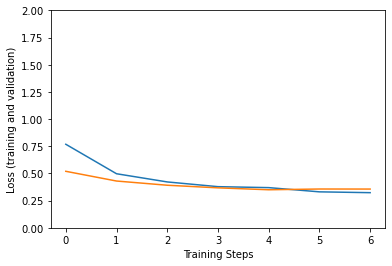

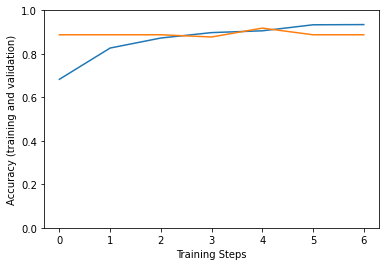

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

/home/jupyter/large-dataset/test-data-large/Good: 73
/home/jupyter/large-dataset/test-data-large/Bad: 98


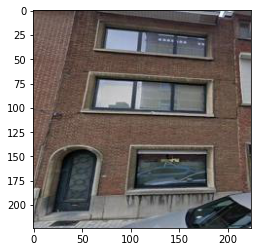

In [11]:
#reading test set of large dataset and augmented
test_data=[]
test_labels=[]
test_imagePaths = []
test_data_dir = "/home/jupyter/large-dataset/test-data-large"
for label in os.listdir(test_data_dir):
    listdir = os.listdir(os.path.sep.join([test_data_dir,label]))
    if label == 'Good':
        bin_label = GOOD
    elif label == 'Bad':
        bin_label = BAD
    for filename in listdir:
        imagePath = os.path.sep.join([test_data_dir, label, filename])
        image = load_img(imagePath)
        plt.imshow(image)
        image = img_to_array(image) / 255.0
        test_data.append(image)
        test_labels.append(bin_label)
        test_imagePaths.append(imagePath)
    print(os.path.sep.join([test_data_dir,label]) + ": " + str(len(test_data)))
test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_imagePaths = np.array(test_imagePaths)

In [12]:
#https://www.tensorflow.org/tutorials/keras/save_and_load?fbclid=IwAR3JVn-_CLqgNuKO3G92cMYCNqVL81oxVs3bP6QhfgFLPiE4VbEMK2QQffc
loss, acc = model.evaluate(test_data, test_labels, verbose=2)

4/4 - 9s - loss: 0.3563 - accuracy: 0.8980


In [13]:
print(len(test_labels))
print("%bad test set: " + str(test_labels.sum()/len(test_labels)))
print(len(val_labels))
print("%bad val set: " + str(val_labels.sum()/len(val_labels)))
print(len(train_labels))
print("%bad train set: " + str(train_labels.sum()/len(train_labels)))

98
%bad test set: 0.25510204081632654
98
%bad val set: 0.2857142857142857
1034
%bad train set: 0.35589941972920697


In [14]:
saved_model_path = "/home/jupyter/Cropping-tuner/DenseNet-LargeDataModel"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /home/jupyter/Cropping-tuner/DenseNet-LargeDataModel/assets


In [15]:
model.save('DenseNet-LargeDatasetModel.h5')